## IDEAS
* Увеличить датасет в 100 раз?
* Target features oof

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

from tqdm import tqdm_notebook as tqdm
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [2]:
data_dir = '/kaggle/input/mlcourse-dota2-win-prediction/'
train = pd.read_csv(os.path.join(data_dir, 'train_features.csv'), index_col='match_id_hash')
target = pd.read_csv(os.path.join(data_dir, 'train_targets.csv'), index_col='match_id_hash')
test = pd.read_csv(os.path.join(data_dir, 'test_features.csv'), index_col='match_id_hash')

train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,2,124,126,0.000000,0,0,0,0,0.000000,0,0,0,0,14,0,1,0,0,304,0,130,700,700,242.93773,1,70,156,0.000000,0,0,1,0,0.000000,0,0,0,0,59,0,0,0,1,389,4,506,399,700,326.93780,2,170,86,0.000000,0,0,0,0,0.000000,0,0,0,0,77,0,0,0,0,402,10,344,422,800,314.93780,2,120,100,0.000000,0,0,0,0,0.000000,0,0,0,0,12,0,0,1,13,982,12,780,650,720,386.93787,3,82,170,0.000000,0,0,1,0,1.00,0,0,0,0,21,0,0,0,6,788,9,706,640,640,422.93790,3,174,90,0.000000,0,0,2,0,0.00,0,0,0,0,60,0,0,0,1,531,0,307,720,720,242.93773,2,180,84,0.299948,0,0,2,0,0.00,0,0,0,0,84,1,0,0

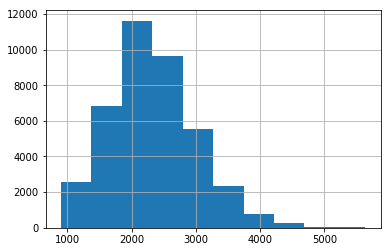

In [43]:
target['duration'].hist()

In [41]:
target.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [3]:
y_train = target.radiant_win

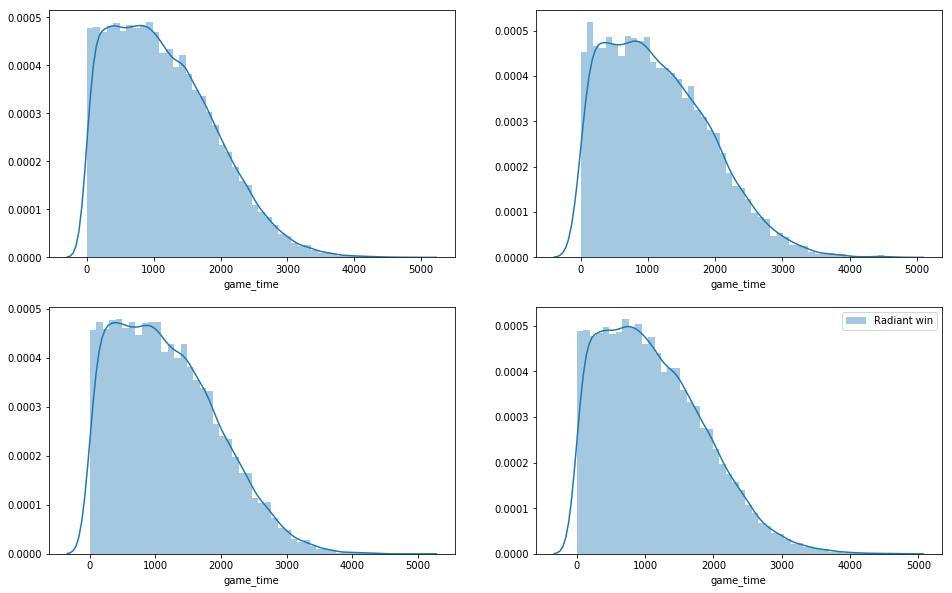

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.distplot(train['game_time'], bins=50, label='Train', ax=axes[0, 0])
sns.distplot(test['game_time'], bins=50, label='Test', ax=axes[0, 1])

sns.distplot(train.loc[y_train==0, 'game_time'], bins=50, label='Dire win', ax=axes[1, 0])
sns.distplot(train.loc[y_train==1, 'game_time'], bins=50, label='Radiant win', ax=axes[1, 1])
plt.legend();

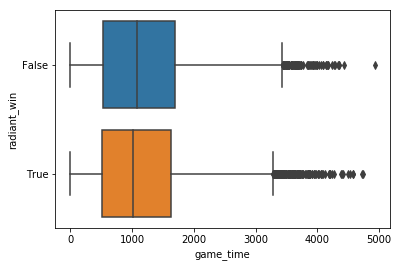

In [5]:
# plt.figure(figsize=(16, 10))

sns.boxplot(x=train.game_time, y=y_train, orient='hor');

In [ ]:
# private|public lobby
print(train['lobby_type'].value_counts(normalize=True))
print(test['lobby_type'].value_counts(normalize=True))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.countplot(train['objectives_len'], ax=axes[0])
sns.countplot(test['objectives_len'], ax=axes[1]);

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.distplot(train['chat_len'], ax=axes[0])
sns.distplot(test['chat_len'], ax=axes[1]);

In [6]:
cols_to_sum = ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level',
               'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation',
               'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed', 'hpp', 'wards']
cols_to_pm =  ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'level',
               'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 
               'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed', 'wards']

for df in [train, test]:
    for team in ['r', 'd']:
        for nplayer in range(1, 6):
            df[f"{team}{nplayer}_kd"] = df[f"{team}{nplayer}_kills"] / (df[f"{team}{nplayer}_deaths"] + 1)
            df[f"{team}{nplayer}_kad"] = (df[f"{team}{nplayer}_kills"] + df[f"{team}{nplayer}_assists"]) / (df[f"{team}{nplayer}_deaths"] + 1)
            df[f"{team}{nplayer}_kahd"] = (df[f"{team}{nplayer}_kills"] + df[f"{team}{nplayer}_assists"] / 2) / (df[f"{team}{nplayer}_deaths"] + 1)
            df[f"{team}{nplayer}_hpp"] = df[f"{team}{nplayer}_health"] / df[f"{team}{nplayer}_max_health"]
            df[f"{team}{nplayer}_wards"] = df[f"{team}{nplayer}_obs_placed"] + df[f"{team}{nplayer}_sen_placed"]
        
        for col in cols_to_sum:
            team_col_name = team + '_' + col
            players_cols = [f"{team}{i}_{col}" for i in range(1, 6)]
            df[team_col_name + '_sum'] = df[players_cols].sum(axis=1)
            df[team_col_name + '_std'] = df[players_cols].std(axis=1)
        
        for col in cols_to_pm:
            for nplayer in range(1, 6):
                col_name = f"{team}{nplayer}_{col}_pm"
                df[col_name] = df[f"{team}{nplayer}_{col}"] / (df["game_time"] / 60)

In [7]:
train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,r1_kd,r1_kad,r1_kahd,r1_hpp,r1_wards,r2_kd,r2_kad,r2_kahd,r2_hpp,r2_wards,r3_kd,r3_kad,r3_kahd,r3_hpp,r3_wards,r4_kd,r4_kad,r4_kahd,r4_hpp,r4_wards,r5_kd,r5_kad,r5_kahd,r5_hpp,r5_wards,r_kills_sum,r_kills_std,r_deaths_sum,r_deaths_std,r_assists_sum,r_assists_std,r_denies_sum,r_denies_std,r_gold_sum,r_gold_std,r_lh_sum,r_lh_std,r_xp_sum,r_xp_std,r_health_sum,r_health_std,r_max_health_sum,r_max_health_std,r_max_mana_sum,r_max_mana_std,r_level_sum,r_level_std,r_x_sum,r_x_std,r_y_sum,r_y_std,r_stuns_sum,r_stuns_std,r_creeps_stacked_sum,r_creeps_stacked_std,r_camps_stacked_sum,r_camps_stacked_std,r_rune_pickups_sum,r_rune_pickups_std,r_firstblood_claimed_sum,r_firstblood_claimed_std,r_teamfight_participation_sum,r_teamfight_participation_std,r_towers_killed_sum,r_towers_killed_std,r_roshans_killed_sum,r_roshans_killed_std,r_obs_placed_sum,r_obs_placed_std,r_sen_placed_sum,r_sen_placed_std,r_hpp_sum,r_hpp_std,r_wards_sum,r_wards_std,r1_kills_pm,r2_kills_pm

In [8]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None, cat_feat=''):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200,
                     categorical_feature=cat_feat)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [9]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [10]:

params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }


In [ ]:

X = train.reset_index(drop=True)
y = target.radiant_win.values
X_test = test.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [ ]:
# pcols = [col[3:] for col in train if 'r1' in col]

# for df in [train, test]:
#     for team in ['r', 'd']:
#         for col in tqdm(pcols):
#             cols_sort = [f'{team}{i}_{col}' for i in range(1, 6)]
#             df[cols_sort] = df[cols_sort].apply(lambda row: row.sort_values(ascending=False).values, axis=1).apply(pd.Series).values

In [21]:
train_sorted = train.copy(deep=True)
test_sorted = test.copy(deep=True)

pcols = [col[3:] for col in train.columns if 'r1' in col]
rpcols = sorted([col for col in train.columns if col[3:] in pcols and col.startswith('r')])
pcols_sorted = [col[3:] for col in rpcols if 'r1' in col]

def sort_players(row):
        return pd.DataFrame(row.values.reshape(5, -1), columns=pcols_sorted).sort_values('gold', ascending=False).to_numpy().flatten()

train_sorted[rpcols] = train_sorted[rpcols].apply(sort_players, axis=1).apply(pd.Series).to_numpy()
test_sorted[rpcols] = test_sorted[rpcols].apply(sort_players, axis=1).apply(pd.Series).to_numpy()

In [ ]:
X = train_sorted.reset_index(drop=True)
y = target.radiant_win.values
X_test = test_sorted.copy().reset_index(drop=True)

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Sat Nov  2 15:02:21 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.912293	valid_1's auc: 0.824704
[2000]	training's auc: 0.958173	valid_1's auc: 0.830747
Early stopping, best iteration is:
[2760]	training's auc: 0.97773	valid_1's auc: 0.831834
Fold 1 started at Sat Nov  2 15:03:14 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.912464	valid_1's auc: 0.82208
[2000]	training's auc: 0.95787	valid_1's auc: 0.829885
[3000]	training's auc: 0.981799	valid_1's auc: 0.832661
[4000]	training's auc: 0.993201	valid_1's auc: 0.833589
Early stopping, best iteration is:
[4770]	training's auc: 0.997295	valid_1's auc: 0.833917
Fold 2 started at Sat Nov  2 15:04:38 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.912895	valid_1's auc: 0.82221
[2000]	training's auc: 0.958268	valid_1's auc: 0.828847
[3000]	training's auc: 0.981989	valid_1's auc: 0.830709
Ear

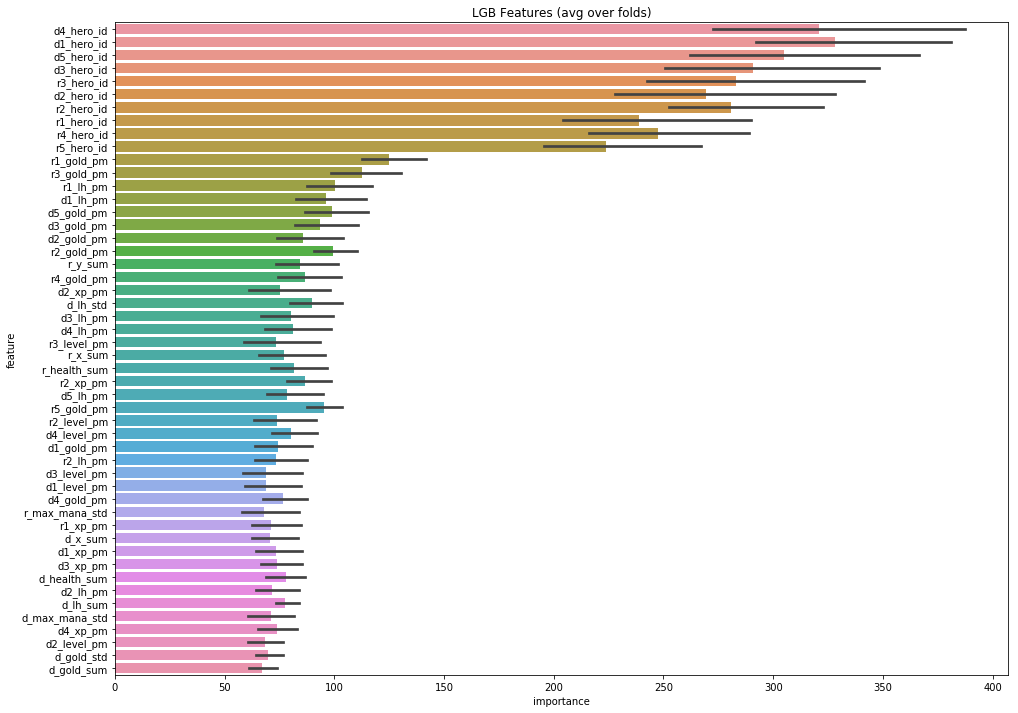

In [22]:
X = train_sorted.reset_index(drop=True)
y = target.radiant_win.values
X_test = test_sorted.copy().reset_index(drop=True)

cat_feat = [i for i in range(len(train_sorted.columns)) if 'id' in train_sorted.columns[i]]

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', 
                                              plot_feature_importance=True, cat_feat=cat_feat)

In [12]:
r_id = [f'r{i}_hero_id' for i in range(1, 6)]
d_id = [f'd{i}_hero_id' for i in range(1, 6)]
h_ids = r_id + d_id

# train_sorted[r_id].apply(lambda row: ' '.join([str(hid) for hid in row]), axis=1)
# hero_ohe = np.zeros((train_sorted.shape[0], 115))
# hero_ohe = pd.DataFrame(np.zeros((train_sorted.shape[0], 115)), columns=[f'hero_{hid}' for hid in np.sort(train_sorted['r1_hero_id'].unique())])
# for col in h_ids:
#     sign = 1 if col.startswith('r') else -1
#     hero_ohe += sign * pd.get_dummies(train_sorted[col]).to_numpy()
    
# pd.concat([train_sorted, pd.DataFrame(hero_ohe, columns=[f'hero_{hid}' for hid in np.sort(train_sorted['r1_hero_id'].unique())])])

In [13]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
ohe.fit(train_sorted[h_ids].to_numpy().reshape(-1, 1))

train_hero_ohe = np.zeros((train_sorted.shape[0], 115))
test_hero_ohe = np.zeros((test_sorted.shape[0], 115))

for col in h_ids:
    sign = 1 if col.startswith('r') else -1
    train_hero_ohe += sign * ohe.transform(train_sorted[col].to_numpy().reshape(-1, 1))
    test_hero_ohe += sign * ohe.transform(test_sorted[col].to_numpy().reshape(-1, 1))

In [14]:
hero_cols_ohe = [f'hero_{hid}' for hid in np.sort(train_sorted['r1_hero_id'].unique())]

Fold 0 started at Sat Nov  2 16:55:20 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.919852	valid_1's auc: 0.836926
[2000]	training's auc: 0.96565	valid_1's auc: 0.839243
Early stopping, best iteration is:
[1976]	training's auc: 0.96495	valid_1's auc: 0.839269
Fold 1 started at Sat Nov  2 16:56:30 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.919843	valid_1's auc: 0.836317
[2000]	training's auc: 0.965584	valid_1's auc: 0.840622
Early stopping, best iteration is:
[2537]	training's auc: 0.979138	valid_1's auc: 0.841153
Fold 2 started at Sat Nov  2 16:57:54 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.920166	valid_1's auc: 0.834766
[2000]	training's auc: 0.965842	valid_1's auc: 0.838331
[3000]	training's auc: 0.987282	valid_1's auc: 0.838824
Early stopping, best iteration is:
[3250]	training's auc: 0.99043	valid_1's auc: 0.838884
Fold 3 started at Sat N

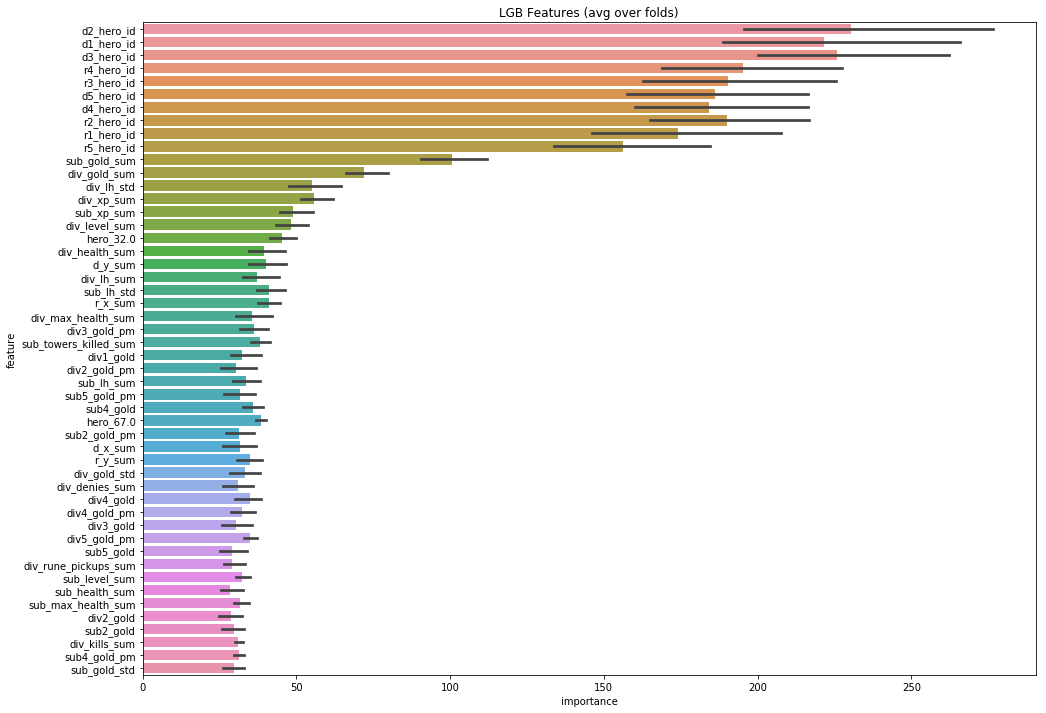

In [38]:
 
X = train_sorted.reset_index(drop=True)
X = pd.concat([X, pd.DataFrame(train_hero_ohe, columns=hero_cols_ohe, index=X.index)], axis=1)
y = target.radiant_win.values
X_test = test_sorted.copy().reset_index(drop=True)
X_test = pd.concat([X_test, pd.DataFrame(test_hero_ohe, columns=hero_cols_ohe, index=X_test.index)], axis=1)

cat_feat = [i for i in range(len(train_sorted.columns)) if 'hero_id' in train_sorted.columns[i]]

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', 
                                              plot_feature_importance=True, cat_feat=cat_feat)

In [ ]:
scores_g = scores.groupby('feature')['importance'].agg(['mean', 'std', 'min', 'max'])
scores_g['spm'] = scores_g['std'] / scores_g['mean']
scores_g = scores_g.sort_values('spm', ascending=False)
scores_g.T

In [ ]:
cols_to_use = scores_g[scores_g['spm'] <= 0.2].index.tolist()

hero_cols_ohe = [f'hero_{hid}' for hid in np.sort(train_sorted['r1_hero_id'].unique())]

X = train_sorted.reset_index(drop=True)
X = pd.concat([X, pd.DataFrame(train_hero_ohe, columns=hero_cols_ohe, index=X.index)], axis=1)
y = target.radiant_win.values
X_test = test_sorted.copy().reset_index(drop=True)
X_test = pd.concat([X_test, pd.DataFrame(test_hero_ohe, columns=hero_cols_ohe, index=X_test.index)], axis=1)

X = X[cols_to_use]
X_test = X_test[cols_to_use]

cat_feat = [i for i in range(len(X.columns)) if 'hero_id' in X.columns[i]]

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', 
                                              plot_feature_importance=True, cat_feat=cat_feat)

In [27]:
pcols_div = [col[3:] for col in train_sorted.columns if col.startswith('r1')][1:]
tcols_div = [col[2:] for col in train_sorted.columns if col.startswith('r_')]

for df in [train_sorted, test_sorted]:
    for nplayer in range(1, 6):
        for col in pcols_div:
            df[f'div{nplayer}_{col}'] = df[f'r{nplayer}_{col}'] / df[f'd{nplayer}_{col}']
            df[f'sub{nplayer}_{col}'] = df[f'r{nplayer}_{col}'] - df[f'd{nplayer}_{col}']
    
    for col in tcols_div:
        df[f'div_{col}'] = df[f'r_{col}'] / df[f'd_{col}']
        df[f'sub_{col}'] = df[f'r_{col}'] - df[f'd_{col}']

Fold 0 started at Sat Nov  2 15:17:42 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.919913	valid_1's auc: 0.834641
[2000]	training's auc: 0.967105	valid_1's auc: 0.837442
[3000]	training's auc: 0.988581	valid_1's auc: 0.83809
Early stopping, best iteration is:
[3077]	training's auc: 0.989498	valid_1's auc: 0.838208
Fold 1 started at Sat Nov  2 15:19:03 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.920476	valid_1's auc: 0.83203
[2000]	training's auc: 0.967567	valid_1's auc: 0.836165
Early stopping, best iteration is:
[2381]	training's auc: 0.977783	valid_1's auc: 0.836613
Fold 2 started at Sat Nov  2 15:20:11 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.92046	valid_1's auc: 0.83192
[2000]	training's auc: 0.967425	valid_1's auc: 0.835981
Early stopping, best iteration is:
[2406]	training's auc: 0.978299	valid_1's auc: 0.836446
Fold 3 started at Sat No

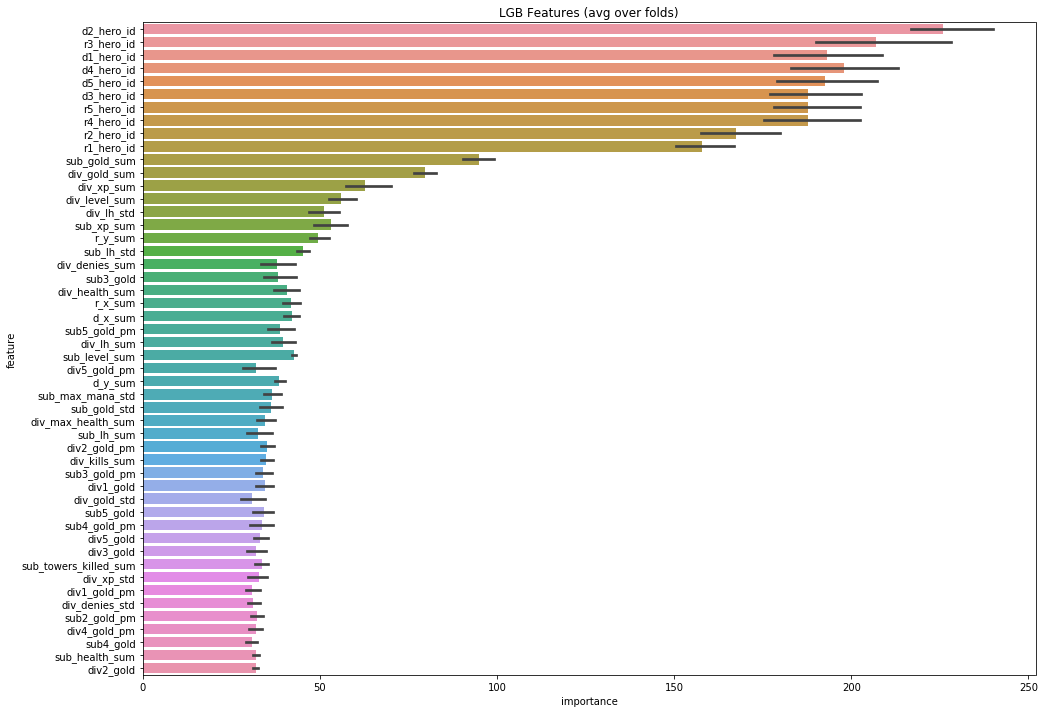

In [28]:
X = train_sorted.reset_index(drop=True)
y = target.radiant_win.values
X_test = test_sorted.copy().reset_index(drop=True)

cat_feat = [i for i in range(len(train_sorted.columns)) if 'id' in train_sorted.columns[i]]

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', 
                                              plot_feature_importance=True, cat_feat=cat_feat)

Fold 0 started at Sat Nov  2 16:46:46 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.91836	valid_1's auc: 0.834735
[2000]	training's auc: 0.965286	valid_1's auc: 0.837539
Early stopping, best iteration is:
[2310]	training's auc: 0.973976	valid_1's auc: 0.837914
Fold 1 started at Sat Nov  2 16:47:57 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.918957	valid_1's auc: 0.832263
[2000]	training's auc: 0.965527	valid_1's auc: 0.836991
[3000]	training's auc: 0.987077	valid_1's auc: 0.837835
[4000]	training's auc: 0.996337	valid_1's auc: 0.838408
Early stopping, best iteration is:
[3943]	training's auc: 0.996063	valid_1's auc: 0.838471
Fold 2 started at Sat Nov  2 16:49:40 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.91905	valid_1's auc: 0.831885
[2000]	training's auc: 0.965362	valid_1's auc: 0.836409
[3000]	training's auc: 0.987139	valid_1's auc: 0.837445
E

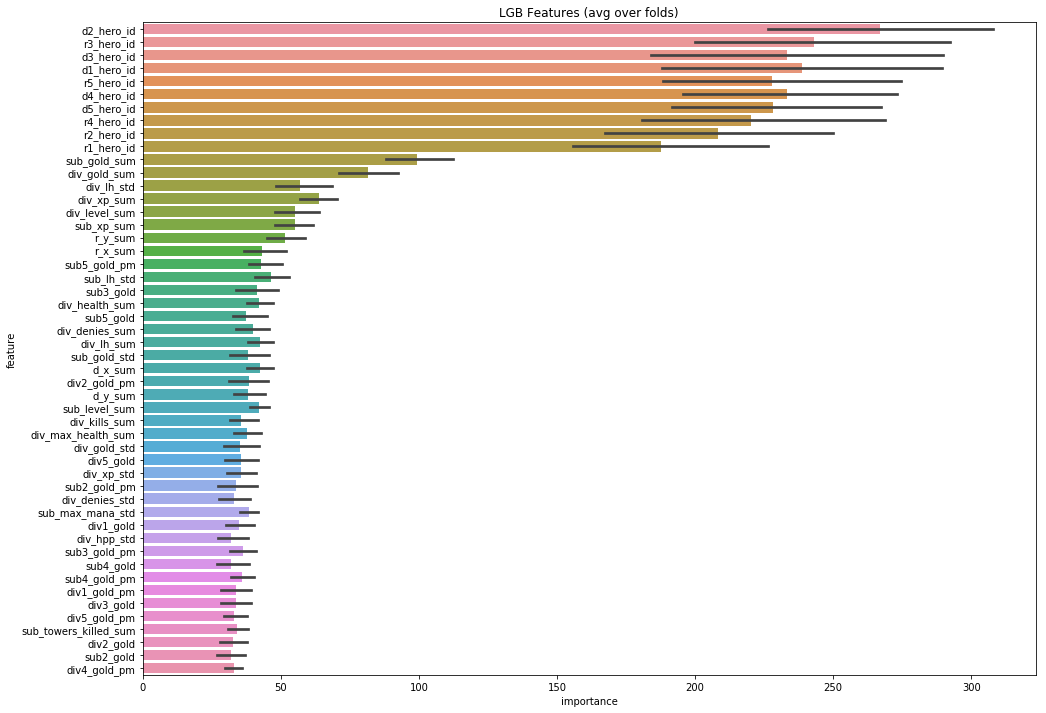

In [37]:
params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary',
          'lambda_l1': 1.0,
         }


X = train_sorted.reset_index(drop=True)
y = target.radiant_win.values
X_test = test_sorted.copy().reset_index(drop=True)

cat_feat = [i for i in range(len(train_sorted.columns)) if 'id' in train_sorted.columns[i]]

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', 
                                              plot_feature_importance=True, cat_feat=cat_feat)

Fold 0 started at Sat Nov  2 19:23:05 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.919852	valid_1's auc: 0.836926
[2000]	training's auc: 0.96565	valid_1's auc: 0.839243
Early stopping, best iteration is:
[1976]	training's auc: 0.96495	valid_1's auc: 0.839269
Fold 1 started at Sat Nov  2 19:24:17 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.919843	valid_1's auc: 0.836317
[2000]	training's auc: 0.965584	valid_1's auc: 0.840622
Early stopping, best iteration is:
[2537]	training's auc: 0.979138	valid_1's auc: 0.841153
Fold 2 started at Sat Nov  2 19:25:42 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.920166	valid_1's auc: 0.834766
[2000]	training's auc: 0.965842	valid_1's auc: 0.838331
[3000]	training's auc: 0.987282	valid_1's auc: 0.838824
Early stopping, best iteration is:
[3250]	training's auc: 0.99043	valid_1's auc: 0.838884
Fold 3 started at Sat N

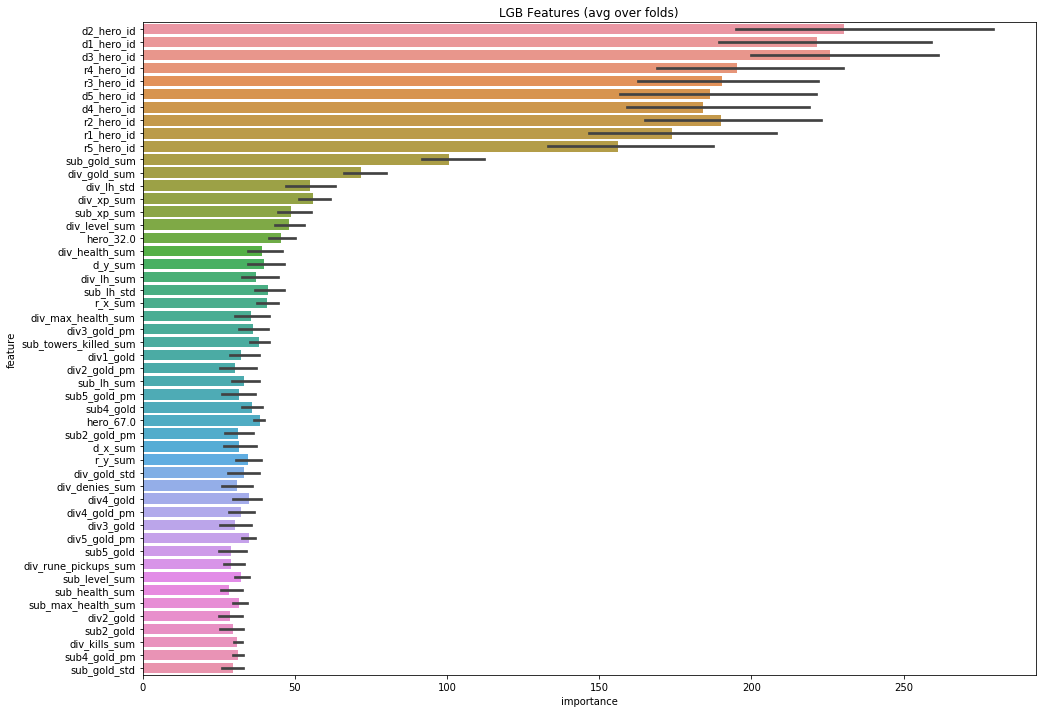

In [56]:
 
X = train_sorted.reset_index(drop=True)
X = pd.concat([X, pd.DataFrame(train_hero_ohe, columns=hero_cols_ohe, index=X.index)], axis=1)
y = target.radiant_win.values
X_test = test_sorted.copy().reset_index(drop=True)
X_test = pd.concat([X_test, pd.DataFrame(test_hero_ohe, columns=hero_cols_ohe, index=X_test.index)], axis=1)

# cat_feat = [i for i in range(len(train_sorted.columns)) if 
#             ('hero_id' in train_sorted.columns[i]) or (train_sorted.columns[i].startswith('hero_'))]
cat_feat = [i for i in range(len(train_sorted.columns)) if 'hero_id' in train_sorted.columns[i]]

oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', 
                                              plot_feature_importance=True, cat_feat=cat_feat)

In [57]:
 
X = train_sorted.reset_index(drop=True)
X = pd.concat([X, pd.DataFrame(train_hero_ohe, columns=hero_cols_ohe, index=X.index)], axis=1)
y = target.radiant_win.values
X_test = test_sorted.copy().reset_index(drop=True)
X_test = pd.concat([X_test, pd.DataFrame(test_hero_ohe, columns=hero_cols_ohe, index=X_test.index)], axis=1)

# cat_feat = [i for i in range(len(train_sorted.columns)) if 
#             ('hero_id' in train_sorted.columns[i]) or (train_sorted.columns[i].startswith('hero_'))]
cols_to_use = [col for col in train_sorted.columns if 'hero_id' not in col]

oof_lgb, prediction_lgb, scores = train_model(X[cols_to_use], X_test[cols_to_use], y, params=params, folds=folds, model_type='lgb', 
                                              plot_feature_importance=True, cat_feat=cat_feat)

Fold 0 started at Sat Nov  2 19:31:34 2019
Training until validation scores don't improve for 200 rounds


KeyboardInterrupt: 

## Parse from json

In [77]:
import json

with open(os.path.join(data_dir, 'train_matches.jsonl')) as fin:
    # read the 18-th line
    for i in range(18):
        line = fin.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

In [73]:
list(match.keys())

['game_time',
 'match_id_hash',
 'teamfights',
 'objectives',
 'chat',
 'game_mode',
 'lobby_type',
 'players',
 'targets']

In [82]:
# barracks [(obj['key'], obj['time']) for obj in match['objectives'] if obj['type'] == 'CHAT_MESSAGE_BARRACKS_KILL']
match['players'][0]

[{'player_slot': 0,
  'hero_id': 103,
  'hero_name': 'npc_dota_hero_elder_titan',
  'account_id_hash': '1c2500195e6ab646fc9371344724aa77',
  'ability_upgrades': [{'ability': 5591, 'time': 255, 'level': 1},
   {'ability': 5589, 'time': 300, 'level': 2},
   {'ability': 5589, 'time': 514, 'level': 3},
   {'ability': 5591, 'time': 564, 'level': 4},
   {'ability': 5589, 'time': 693, 'level': 5},
   {'ability': 5594, 'time': 813, 'level': 6},
   {'ability': 5589, 'time': 872, 'level': 7},
   {'ability': 5593, 'time': 969, 'level': 8},
   {'ability': 5593, 'time': 1098, 'level': 9},
   {'ability': 5919, 'time': 1326, 'level': 10},
   {'ability': 5593, 'time': 1516, 'level': 11},
   {'ability': 5594, 'time': 1717, 'level': 12},
   {'ability': 5593, 'time': 1732, 'level': 13},
   {'ability': 5591, 'time': 1918, 'level': 14},
   {'ability': 6171, 'time': 2007, 'level': 15},
   {'ability': 5591, 'time': 2173, 'level': 16},
   {'ability': 5594, 'time': 2216, 'level': 17},
   {'ability': 6378, 'tim

In [ ]:
# from eli5.permutation_importance import get_score_importances

# # ... load data, define score function
# def score(X, y):
#     y_pred = predict(X)
#     return accuracy(y, y_pred)

# base_score, score_decreases = get_score_importances(score, X, y)
# feature_importances = np.mean(score_decreases, axis=0)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# params = {'boost': 'gbdt',
#           'learning_rate': 0.01,
#           'metric':'auc',
#           'num_threads': -1,
#           'verbosity': 1,
#           'objective': 'binary',
#           'num_boost_round': 3500,
#           'random_state': 42
#          }

# grid_params = {
#             'min_data_in_leaf': [25, 50, 75, 100],
#           'num_leaves': [16, 24, 32, 40, 48, 56, 64],
#           'max_depth': [-1, 7, 11, 15, 21, 25],  
#           'feature_fraction': [0.05, 0.1, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]
# }

# model = lgb.LGBMClassifier(**params)

# gs = RandomizedSearchCV(model, grid_params, n_iter=10, scoring='roc_auc', cv=folds, verbose=2)
# gs.fit(train_sorted, y)
# gs.best_score_

{'num_leaves': 48,
 'min_data_in_leaf': 100,
 'max_depth': 25,
 'feature_fraction': 0.1}

In [ ]:
sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
sub['radiant_win_prob'] = prediction_lgb
sub.to_csv('submission.csv', index=False)
sub.head()